In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Import

In [0]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Activation, LSTM, GRU, SpatialDropout1D, Flatten, Bidirectional, CuDNNGRU, CuDNNLSTM, GlobalMaxPool1D, Layer, BatchNormalization, TimeDistributed

from tensorflow.keras import utils,initializers,regularizers,constraints,activations
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

#Kaggle, load data

In [2]:
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

#Загружаем данные с сайта Kaggle

!kaggle competitions download -c neural-university-imdb-spring2019


kaggle.json
  0% 0.00/77.1k [00:00<?, ?B/s]
100% 77.1k/77.1k [00:00<00:00, 31.9MB/s]
  0% 0.00/3.31M [00:00<?, ?B/s]
100% 3.31M/3.31M [00:00<00:00, 108MB/s]
 68% 9.00M/13.3M [00:00<00:00, 17.5MB/s]
100% 13.3M/13.3M [00:00<00:00, 24.7MB/s]


In [3]:
!unzip imdb_test.npy.zip
!unzip imdb_train.npz.zip

Archive:  imdb_test.npy.zip
  inflating: imdb_test.npy           
Archive:  imdb_train.npz.zip
  inflating: imdb_train.npz          


In [13]:
data = np.load('imdb_train.npz', allow_pickle=True) 
train_x = data['x'] 
train_y = data['y']

test_x = np.load('imdb_test.npy', allow_pickle=True)

maxlen = 1000
train_X = pad_sequences(train_x, maxlen=maxlen)
test_X = pad_sequences(test_x, maxlen=maxlen)

word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items()}

1646592/1641221 [==============================] - 0s 0us/step


##GloVe

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip  

--2019-06-19 04:54:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-19 04:54:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-19 04:54:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
def glove_embedings(embedding_len):
  from tqdm import tqdm
  import os, re, csv, math, codecs

  #load embeddings
  print('loading word embeddings...')
  embeddings_index = {}
  f = codecs.open('glove.6B.{}d.txt'.format(embedding_len), encoding='utf-8')
  for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print('found %s word vectors' % len(embeddings_index))
  return embeddings_index
  

In [14]:
num_words = 20000
embedding_len = 300
embeddings_index = glove_embedings(embedding_len)

embedding_matrix = np.zeros((num_words, embedding_len))
for word, i in word_index.items():
    if i < num_words - 3:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i + 3] = embedding_vector

962it [00:00, 9615.52it/s]

loading word embeddings...


400000it [00:40, 9851.02it/s]


found 400000 word vectors


#AttentionWithContext class

In [0]:
#https://gist.github.com/iridiumblue/622a9525189d48e9c00659fea269bfa4

# AttentionWithContext adapted for Tensorflow 1.13 with Eager Execution.
# IMPORTANT -you can't use regular keras optimizers.  You need to grab one that is subclassed from 
# tf.train.Optimizer.   Not to worry, your favorite is probably there, for example - 
# https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer

# That's it, now you can use this layer - 
# Adapted from https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2

# Tested using functional API.   Just plop on top of an RNN, like so - 

# x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], input_length=max_topic_length, trainable=False)(inputs)
# x1 = LSTM(return_sequences=True)(x)
# c1 = AttentionWithContext()(x1)

import tensorflow as tf
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Layer

class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False, **kwargs):

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        input_shape_list = input_shape.as_list()

        self.W = self.add_weight(shape=((input_shape_list[-1], input_shape_list[-1])),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape_list[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape_list[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape.as_list())

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = activations.tanh(uit)
        # ait = K.dot(uit, self.u)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = activations.exponential(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            #TODO use TensorShape here, as done in the else statement.   I'm not sure
            # if this is returning a single tensor, or a list of two so leaving this undone for now.  Suspect this will
            # need to complete if using Sequential rather than Functional API
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])

In [0]:
!ls /content/drive/'My Drive'

#Model

In [0]:
from tensorflow.keras.layers import RepeatVector, Permute, Multiply, Lambda
from tensorflow.keras import backend as K

def create_model(params):
  model = Sequential()
  model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix]))
  model.add(SpatialDropout1D(0.4))
  model.add(Bidirectional(CuDNNLSTM(params['units'], return_sequences=True)))
  model.add(AttentionWithContext())
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

#Fit

In [15]:
params = {'units': 256, 'lr': .002, 'drop_lr': .75 }
model = create_model(params)

#model.load_weights('nlp.hfd5')
сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)
def step_decay(epoch):
  initial_lrate = params['lr']
  drop = params['drop_lr']
  epochs_drop = 1
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay,verbose=0)


history = model.fit(train_X, 
                    train_y, 
                    epochs=30,
                    batch_size=128,
                    callbacks = [lrate,сheckpoint],
                    validation_split=0.1,
                    verbose=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/30
36000/36000 [==============================] - 151s 4ms/sample - loss: 0.5416 - acc: 0.6865 - val_loss: 0.4141 - val_acc: 0.8687
Epoch 2/30
36000/36000 [==============================] - 149s 4ms/sample - loss: 0.2466 - acc: 0.8992 - val_loss: 0.2036 - val_acc: 0.9195
Epoch 3/30
36000/36000 [==============================] - 150s 4ms/sample - loss: 0.1959 - acc: 0.9233 - val_loss: 0.2016 - val_acc: 0.9240
Epoch 4/30
36000/36000 [==============================] - 149s 4ms/sample - loss: 0.1670 - acc: 0.9348 - val_loss: 0.2058 - val_acc: 0.9268
Epoch 5/30
36000/36000 [==============================] - 150s 4ms/sample - loss: 0.1478 - acc: 0.9441 - val_loss: 0.1987 - val_acc: 0.9280
Epoch 6/30
36000/36000 [==============================] - 149s 4ms/sample - loss: 0.1322 - acc: 0.9524 - val_loss: 0.1908 - val_acc: 0.9287
Epoch 7/30
36000/36000 [==============================] - 150s 4ms/sample - loss: 0.1213 - acc: 0.9556 - val_lo

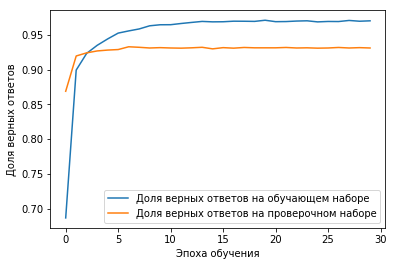

In [16]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Kaggle submit

In [0]:

#model = create_model(params)
model.load_weights('nlp.hfd5')
predictions = model.predict(test_X)

In [18]:
predictions = predictions.round()
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))
np.savetxt('submission.csv', out, header="Id,Category", comments="", fmt="%d,%d")
!head submission.csv

Id,Category
1,1
2,1
3,0
4,0
5,1
6,0
7,0
8,1
9,0


In [19]:
!kaggle competitions submit -c neural-university-imdb-spring2019 -m "Baseline submition from Colab" -f submission.csv

100% 67.3k/67.3k [00:05<00:00, 12.1kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-36: ordinal not in range(256)


#Conclusion

[colab](https://colab.research.google.com/drive/1-BPvHSCm1GA2Oal-8axrReWvwqAWamsC)

Второе место в соревновании. В качестве архитектуры использована двунаправленная сеть с LSTM слоем и слоем внимания.  В качестве признаков использовано векторное представление слов GloVe длиной 300,  с 20000 словами. 

#Хлам

In [0]:
from tensorflow.keras.layers import RepeatVector, Permute, Multiply, Lambda
from tensorflow.keras import backend as K

def create_model2(params):
  model = Sequential()
  model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix]))
  model.add(SpatialDropout1D(0.4))
  #model.add(LSTM(100, return_sequences=True))
  model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
  model.add(AttentionWithContext())
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

def create_model1(params):
  inp = Input(shape=(maxlen,))
  x = Embedding(num_words, embedding_len, weights=[embedding_matrix])(inp)
  x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
  max_pool = GlobalMaxPool1D()(x)
  atten = AttentionLSTM(maxlen)(x)
  #atten = AttentionLayer(name='attention')(x)
  #atten = Attention((maxlen,))(x)
  x = Concatenate(axis=-1)([max_pool, atten])
  
  x = Dense(8, activation="relu")(x)
  x = Dropout(0.4)(x)
  x = BatchNormalization()(x)

  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

def create_model(params):
  inp = Input(shape=(maxlen,))
  x = Embedding(num_words, embedding_len, weights=[embedding_matrix])(inp)
  x = Bidirectional(CuDNNLSTM(params['units'], return_sequences=True))(x)
  
  attention = TimeDistributed(Dense(1, activation='tanh'))(x) 
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(params['units']*2)(attention)
  attention = Permute([2, 1])(attention)

  # apply the attention
  merged = Multiply()([x, attention])
  x = Lambda(lambda xin: K.sum(xin, axis=1))(merged)  
  
  x = Dense(16, activation="relu")(x)
  x = Dropout(0.4)(x)
  x = BatchNormalization()(x)

  preds = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=preds)
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model






Train on 36000 samples, validate on 4000 samples
Epoch 1/30
36000/36000 [==============================] - 76s 2ms/sample - loss: 0.4130 - acc: 0.8048 - val_loss: 0.4278 - val_acc: 0.8303
Epoch 2/30
36000/36000 [==============================] - 72s 2ms/sample - loss: 0.2669 - acc: 0.8898 - val_loss: 0.3089 - val_acc: 0.8692
Epoch 3/30
36000/36000 [==============================] - 72s 2ms/sample - loss: 0.2263 - acc: 0.9086 - val_loss: 0.2026 - val_acc: 0.9220
Epoch 4/30
36000/36000 [==============================] - 72s 2ms/sample - loss: 0.2034 - acc: 0.9200 - val_loss: 0.2097 - val_acc: 0.9193
Epoch 5/30
36000/36000 [==============================] - 72s 2ms/sample - loss: 0.1893 - acc: 0.9260 - val_loss: 0.2097 - val_acc: 0.9227
Epoch 6/30
36000/36000 [==============================] - 72s 2ms/sample - loss: 0.1803 - acc: 0.9293 - val_loss: 0.1963 - val_acc: 0.9265
Epoch 7/30
36000/36000 [==============================] - 72s 2ms/sample - loss: 0.1721 - acc: 0.9330 - val_loss: 0.1

In [0]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
!cp nlp.hfd5 ./drive/'My Drive'/nlp_9x.hfd5

In [0]:

def create_model(params):
  model = Sequential()
  #model.add(Embedding(num_words, embedding_matrix, input_length=maxlen))
  model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix], input_length=maxlen, trainable=False))
  model.add(SpatialDropout1D(0.4))
  model.add(Bidirectional(LSTM(400, dropout=0.2, recurrent_dropout=0.2)))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])  
  return model

In [0]:
params = {'lr': .001, 'drop_lr': .7 }
model = create_model(params)
model.load_weights('/content/drive/My Drive/nlpbd.hfd5')



W0618 04:30:39.156525 139842466908032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0618 04:30:42.111627 139842466908032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0618 04:30:42.116964 139842466908032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init

In [0]:
# params = {'lr': .001, 'drop_lr': .7 }
# model = create_model(params)

def step_decay(epoch):
  initial_lrate = params['lr']
  drop = params['drop_lr']
  epochs_drop = 5.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay,verbose=0)
сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)



history = model.fit(train_X, 
                    train_y, 
                    epochs=10,
                    batch_size=64,
                    callbacks = [lrate,сheckpoint],
                    validation_split=0.1,
                    verbose=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 2318s 64ms/sample - loss: 0.2556 - acc: 0.8984 - val_loss: 0.3098 - val_acc: 0.8752
Epoch 2/10
36000/36000 [==============================] - 2321s 64ms/sample - loss: 0.2394 - acc: 0.9041 - val_loss: 0.2494 - val_acc: 0.9062
Epoch 3/10
36000/36000 [==============================] - 2313s 64ms/sample - loss: 0.2603 - acc: 0.8910 - val_loss: 0.2241 - val_acc: 0.9130
Epoch 4/10
36000/36000 [==============================] - 2296s 64ms/sample - loss: 0.2543 - acc: 0.8971 - val_loss: 0.2394 - val_acc: 0.9097
Epoch 5/10
36000/36000 [==============================] - 2309s 64ms/sample - loss: 0.2365 - acc: 0.9036 - val_loss: 0.2287 - val_acc: 0.9100
Epoch 6/10
36000/36000 [==============================] - 2298s 64ms/sample - loss: 0.2174 - acc: 0.9129 - val_loss: 0.2190 - val_acc: 0.9097
Epoch 7/10
36000/36000 [==============================] - 2287s 64ms/sample - loss: 0.2043 - acc: 0

##predict

In [0]:
#model = create_model(params)
model.load_weights('nlp.hfd5')
predictions = model.predict(test_X)

In [0]:
predictions = predictions.round()
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))
np.savetxt('submission.csv', out, header="Id,Category", comments="", fmt="%d,%d")
!head submission.csv

In [0]:
!kaggle competitions submit -c neural-university-imdb-spring2019 -m "Baseline submition from Colab" -f submission.csv

In [0]:
!cp nlp.hfd5 /content/drive/'My Drive'/nlpbd.hfd5

In [0]:
class AttentionLSTM(LSTM):
    """LSTM with attention mechanism
    This is an LSTM incorporating an attention mechanism into its hidden states.
    Currently, the context vector calculated from the attended vector is fed
    into the model's internal states, closely following the model by Xu et al.
    (2016, Sec. 3.1.2), using a soft attention model following
    Bahdanau et al. (2014).
    The layer expects two inputs instead of the usual one:
        1. the "normal" layer input; and
        2. a 3D vector to attend.
    Args:
        attn_activation: Activation function for attentional components
        attn_init: Initialization function for attention weights
        output_alpha (boolean): If true, outputs the alpha values, i.e.,
            what parts of the attention vector the layer attends to at each
            timestep.
    References:
        * Bahdanau, Cho & Bengio (2014), "Neural Machine Translation by Jointly
          Learning to Align and Translate", <https://arxiv.org/pdf/1409.0473.pdf>
        * Xu, Ba, Kiros, Cho, Courville, Salakhutdinov, Zemel & Bengio (2016),
          "Show, Attend and Tell: Neural Image Caption Generation with Visual
          Attention", <http://arxiv.org/pdf/1502.03044.pdf>
    See Also:
        `LSTM`_ in the Keras documentation.
        .. _LSTM: http://keras.io/layers/recurrent/#lstm
    """
    def __init__(self, *args, attn_activation='tanh', attn_init='orthogonal',
                 output_alpha=False, **kwargs):
        self.attn_activation = activations.get(attn_activation)
        #self.attn_init = initializations.get(attn_init)
        self.attn_init = initializers.get(attn_init)
        self.output_alpha = output_alpha
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        if not (isinstance(input_shape, list) and len(input_shape) == 2):
            raise Exception('Input to AttentionLSTM must be a list of '
                            'two tensors [lstm_input, attn_input].')

        input_shape, attn_input_shape = input_shape
        super().build(input_shape)
        self.input_spec.append(InputSpec(shape=attn_input_shape))

        # weights for attention model
        self.U_att = self.inner_init((self.output_dim, self.output_dim),
                                     name='{}_U_att'.format(self.name))
        self.W_att = self.attn_init((attn_input_shape[-1], self.output_dim),
                                    name='{}_W_att'.format(self.name))
        self.v_att = self.init((self.output_dim, 1),
                               name='{}_v_att'.format(self.name))
        self.b_att = K.zeros((self.output_dim,), name='{}_b_att'.format(self.name))
        self.trainable_weights += [self.U_att, self.W_att, self.v_att, self.b_att]

        # weights for incorporating attention into hidden states
        if self.consume_less == 'gpu':
            self.Z = self.init((attn_input_shape[-1], 4 * self.output_dim),
                               name='{}_Z'.format(self.name))
            self.trainable_weights += [self.Z]
        else:
            self.Z_i = self.attn_init((attn_input_shape[-1], self.output_dim),
                                      name='{}_Z_i'.format(self.name))
            self.Z_f = self.attn_init((attn_input_shape[-1], self.output_dim),
                                      name='{}_Z_f'.format(self.name))
            self.Z_c = self.attn_init((attn_input_shape[-1], self.output_dim),
                                      name='{}_Z_c'.format(self.name))
            self.Z_o = self.attn_init((attn_input_shape[-1], self.output_dim),
                                      name='{}_Z_o'.format(self.name))
            self.trainable_weights += [self.Z_i, self.Z_f, self.Z_c, self.Z_o]
            self.Z = K.concatenate([self.Z_i, self.Z_f, self.Z_c, self.Z_o])

        # weights for initializing states based on attention vector
        if not self.stateful:
            self.W_init_c = self.attn_init((attn_input_shape[-1], self.output_dim),
                                           name='{}_W_init_c'.format(self.name))
            self.W_init_h = self.attn_init((attn_input_shape[-1], self.output_dim),
                                           name='{}_W_init_h'.format(self.name))
            self.b_init_c = K.zeros((self.output_dim,),
                                    name='{}_b_init_c'.format(self.name))
            self.b_init_h = K.zeros((self.output_dim,),
                                    name='{}_b_init_h'.format(self.name))
            self.trainable_weights += [self.W_init_c, self.b_init_c,
                                       self.W_init_h, self.b_init_h]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def get_output_shape_for(self, input_shape):
        # output shape is not affected by the attention component
        return super().get_output_shape_for(input_shape[0])

    def compute_mask(self, input, input_mask=None):
        if input_mask is not None:
            input_mask = input_mask[0]
        return super().compute_mask(input, input_mask=input_mask)

    def get_initial_states(self, x_input, x_attn, mask_attn):
        # set initial states from mean attention vector fed through a dense
        # activation
        mean_attn = K.mean(x_attn * K.expand_dims(mask_attn), axis=1)
        h0 = K.dot(mean_attn, self.W_init_h) + self.b_init_h
        c0 = K.dot(mean_attn, self.W_init_c) + self.b_init_c
        return [self.attn_activation(h0), self.attn_activation(c0)]

    def call(self, x, mask=None):
        assert isinstance(x, list) and len(x) == 2
        x_input, x_attn = x
        if mask is not None:
            mask_input, mask_attn = mask
        else:
            mask_input, mask_attn = None, None
        # input shape: (nb_samples, time (padded with zeros), input_dim)
        input_shape = self.input_spec[0].shape
        if K._BACKEND == 'tensorflow':
            if not input_shape[1]:
                raise Exception('When using TensorFlow, you should define '
                                'explicitly the number of timesteps of '
                                'your sequences.\n'
                                'If your first layer is an Embedding, '
                                'make sure to pass it an "input_length" '
                                'argument. Otherwise, make sure '
                                'the first layer has '
                                'an "input_shape" or "batch_input_shape" '
                                'argument, including the time axis. '
                                'Found input shape at layer ' + self.name +
                                ': ' + str(input_shape))
        if self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(x_input, x_attn, mask_attn)
        constants = self.get_constants(x_input, x_attn, mask_attn)
        preprocessed_input = self.preprocess_input(x_input)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                             initial_states,
                                             go_backwards=self.go_backwards,
                                             mask=mask_input,
                                             constants=constants,
                                             unroll=self.unroll,
                                             input_length=input_shape[1])
        if self.stateful:
            self.updates = []
            for i in range(len(states)):
                self.updates.append((self.states[i], states[i]))

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def step(self, x, states):
        h_tm1 = states[0]
        c_tm1 = states[1]
        B_U = states[2]
        B_W = states[3]
        x_attn = states[4]
        mask_attn = states[5]
        attn_shape = self.input_spec[1].shape

        #### attentional component
        # alignment model
        # -- keeping weight matrices for x_attn and h_s separate has the advantage
        # that the feature dimensions of the vectors can be different
        h_att = K.repeat(h_tm1, attn_shape[1])
        att = time_distributed_dense(x_attn, self.W_att, self.b_att)
        energy = self.attn_activation(K.dot(h_att, self.U_att) + att)
        energy = K.squeeze(K.dot(energy, self.v_att), 2)
        # make probability tensor
        alpha = K.exp(energy)
        if mask_attn is not None:
            alpha *= mask_attn
        alpha /= K.sum(alpha, axis=1, keepdims=True)
        alpha_r = K.repeat(alpha, attn_shape[2])
        alpha_r = K.permute_dimensions(alpha_r, (0, 2, 1))
        # make context vector -- soft attention after Bahdanau et al.
        z_hat = x_attn * alpha_r
        z_hat = K.sum(z_hat, axis=1)

        if self.consume_less == 'gpu':
            z = K.dot(x * B_W[0], self.W) + K.dot(h_tm1 * B_U[0], self.U) \
                + K.dot(z_hat, self.Z) + self.b

            z0 = z[:, :self.output_dim]
            z1 = z[:, self.output_dim: 2 * self.output_dim]
            z2 = z[:, 2 * self.output_dim: 3 * self.output_dim]
            z3 = z[:, 3 * self.output_dim:]
        else:
            if self.consume_less == 'cpu':
                x_i = x[:, :self.output_dim]
                x_f = x[:, self.output_dim: 2 * self.output_dim]
                x_c = x[:, 2 * self.output_dim: 3 * self.output_dim]
                x_o = x[:, 3 * self.output_dim:]
            elif self.consume_less == 'mem':
                x_i = K.dot(x * B_W[0], self.W_i) + self.b_i
                x_f = K.dot(x * B_W[1], self.W_f) + self.b_f
                x_c = K.dot(x * B_W[2], self.W_c) + self.b_c
                x_o = K.dot(x * B_W[3], self.W_o) + self.b_o
            else:
                raise Exception('Unknown `consume_less` mode.')

            z0 = x_i + K.dot(h_tm1 * B_U[0], self.U_i) + K.dot(z_hat, self.Z_i)
            z1 = x_f + K.dot(h_tm1 * B_U[1], self.U_f) + K.dot(z_hat, self.Z_f)
            z2 = x_c + K.dot(h_tm1 * B_U[2], self.U_c) + K.dot(z_hat, self.Z_c)
            z3 = x_o + K.dot(h_tm1 * B_U[3], self.U_o) + K.dot(z_hat, self.Z_o)

        i = self.inner_activation(z0)
        f = self.inner_activation(z1)
        c = f * c_tm1 + i * self.activation(z2)
        o = self.inner_activation(z3)

        h = o * self.activation(c)
        if self.output_alpha:
            return alpha, [h, c]
        else:
            return h, [h, c]

    def get_constants(self, x_input, x_attn, mask_attn):
        constants = super().get_constants(x_input)
        attn_shape = self.input_spec[1].shape
        if mask_attn is not None:
            if K.ndim(mask_attn) == 3:
                mask_attn = K.all(mask_attn, axis=-1)
        constants.append(x_attn)
        constants.append(mask_attn)
        return constants

    def get_config(self):
        cfg = super().get_config()
        cfg['output_alpha'] = self.output_alpha
        cfg['attn_activation'] = self.attn_activation.__name__
        return cfg

    @classmethod
    def from_config(cls, config):
        instance = super(AttentionLSTM, cls).from_config(config)
        if 'output_alpha' in config:
            instance.output_alpha = config['output_alpha']
        if 'attn_activation' in config:
            instance.attn_activation = activations.get(config['attn_activation'])
        return instance

In [0]:
# не работает
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [0]:
#--
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
#--
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

#         self.W_a = self.add_weight(name='W_a',
#                                    shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
#                                    initializer='uniform',
#                                    trainable=True)
#         self.U_a = self.add_weight(name='U_a',
#                                    shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
#                                    initializer='uniform',
#                                    trainable=True)
#         self.V_a = self.add_weight(name='V_a',
#                                    shape=tf.TensorShape((input_shape[0][2], 1)),
#                                    initializer='uniform',
#                                    trainable=True)
        
        print(input_shape)
        self.W = self.add_weight(shape=tf.TensorShape(input_shape),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=tf.TensorShape(input_shape[2], )),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
from tensorflow.keras.layers import RepeatVector, Permute, Multiply, Lambda
def create_model1(params):
  inp = Input(shape=(maxlen,))
  x = Embedding(num_words, embedding_len, weights=[embedding_matrix])(inp)
  x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
  max_pool = GlobalMaxPool1D()(x)
  atten = AttentionLSTM(maxlen)(x)
  #atten = AttentionLayer(name='attention')(x)
  #atten = Attention((maxlen,))(x)
  x = Concatenate(axis=-1)([max_pool, atten])
  
  x = Dense(8, activation="relu")(x)
  x = Dropout(0.4)(x)
  x = BatchNormalization()(x)

  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

def create_model(params):
  inp = Input(shape=(maxlen,))
  x = Embedding(num_words, embedding_len, weights=[embedding_matrix])(inp)
  x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
  
  attention = TimeDistributed(Dense(1, activation='tanh'))(x) 
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(128)(attention)
  attention = Permute([2, 1])(attention)

  # apply the attention
  merged = Multiply()([x, attention])
  merged = Lambda(lambda xin: K.sum(xin, axis=1))(merged)  
  
#   # attention
#   attention = TimeDistributed(Dense(1, activation='tanh'))(x) 
#   attention = Flatten()(attention)
#   attention = Activation('softmax')(attention)

#   merged = Merge([x, attention], mode='mul')  
#   merged = BatchNormalization()(merged)

  preds = Dense(1, activation="sigmoid")(merged)
  model = Model(inputs=inp, outputs=preds)
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model




params = {'lr': .002, 'drop_lr': .75 }
model = create_model(params)

#model.load_weights('nlp92.hfd5')
сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)
def step_decay(epoch):
  initial_lrate = params['lr']
  drop = params['drop_lr']
  epochs_drop = 1
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay,verbose=0)


history = model.fit(train_X, 
                    train_y, 
                    epochs=10,
                    batch_size=128,
                    callbacks = [lrate,сheckpoint],
                    validation_split=0.1,
                    verbose=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 52s 1ms/sample - loss: 0.3804 - acc: 0.8256 - val_loss: 0.2285 - val_acc: 0.9107
Epoch 2/10
36000/36000 [==============================] - 46s 1ms/sample - loss: 0.1993 - acc: 0.9223 - val_loss: 0.2058 - val_acc: 0.9222
Epoch 3/10
36000/36000 [==============================] - 46s 1ms/sample - loss: 0.1480 - acc: 0.9452 - val_loss: 0.2162 - val_acc: 0.9185
Epoch 4/10
36000/36000 [==============================] - 46s 1ms/sample - loss: 0.1123 - acc: 0.9592 - val_loss: 0.2118 - val_acc: 0.9197
Epoch 5/10
36000/36000 [==============================] - 46s 1ms/sample - loss: 0.0856 - acc: 0.9706 - val_loss: 0.2426 - val_acc: 0.9145
Epoch 6/10
36000/36000 [==============================] - 47s 1ms/sample - loss: 0.0666 - acc: 0.9779 - val_loss: 0.2606 - val_acc: 0.9160
Epoch 7/10
36000/36000 [==============================] - 46s 1ms/sample - loss: 0.0532 - acc: 0.9828 - val_loss: 0.2

In [0]:
!ls

sample_data


In [0]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:

      
def create_model2(params):
  features_input = Input(shape=(train_X.shape[1],))
  inp = Input(shape=(maxlen, ))
  x = Embedding(num_words, embedding_len, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inp)

  x = SpatialDropout1D(.1)(x)
  x = Bidirectional(CuDNNLSTM(120, return_sequences=True))(x)
  y = Bidirectional(CuDNNGRU(120, return_sequences=True))(x)
  atten_1 = Attention(maxlen)(x) # skip connect
  atten_2 = Attention(maxlen)(y)
  avg_pool = GlobalAveragePooling1D()(y)
  max_pool = GlobalMaxPooling1D()(y)
  x = concatenate([atten_1, atten_2, avg_pool, max_pool,features_input])
  x = Dense(720, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(16, activation="relu")(x)
  x = Dropout(0.1)(x)
  
  # Output dense layer with one output for our Binary Classification problem.
  outp = Dense(1, activation="sigmoid")(x)
  # Some keras model creation and compiling
  model = Model(inputs=[inp,features_input], outputs=outp)
  
  model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])  
  
  return model

params = {'lr': .001, 'drop_lr': .7 }
model = create_model2(params)
сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)



history = model.fit(train_X, 
                    train_y, 
                    epochs=10,
                    batch_size=128,
                    callbacks = [сheckpoint],
                    validation_split=0.1,
                    verbose=1)

In [0]:
def create_model(params):
  inp = Input(shape=(maxlen,))
  x = Embedding(num_words, embedding_len, weights=[embedding_matrix])(inp)
  x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
  x = GlobalMaxPool1D()(x)
  
  x = Dense(8, activation="relu")(x)
  x = Dropout(0.4)(x)
  x = BatchNormalization()(x)

  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

params = {'lr': .002, 'drop_lr': .75 }
model = create_model(params)

#model.load_weights('nlp92.hfd5')
сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)
def step_decay(epoch):
  initial_lrate = params['lr']
  drop = params['drop_lr']
  epochs_drop = 1
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay,verbose=0)


history = model.fit(train_X, 
                    train_y, 
                    epochs=10,
                    batch_size=128,
                    callbacks = [lrate,сheckpoint],
                    validation_split=0.1,
                    verbose=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 46s 1ms/sample - loss: 0.4150 - acc: 0.8120 - val_loss: 0.2732 - val_acc: 0.8945
Epoch 2/10
36000/36000 [==============================] - 44s 1ms/sample - loss: 0.2534 - acc: 0.9021 - val_loss: 0.2059 - val_acc: 0.9205
Epoch 3/10
36000/36000 [==============================] - 44s 1ms/sample - loss: 0.1880 - acc: 0.9332 - val_loss: 0.2741 - val_acc: 0.8838
Epoch 4/10
36000/36000 [==============================] - 44s 1ms/sample - loss: 0.1350 - acc: 0.9556 - val_loss: 0.2356 - val_acc: 0.9038
Epoch 5/10
36000/36000 [==============================] - 44s 1ms/sample - loss: 0.0959 - acc: 0.9701 - val_loss: 0.2447 - val_acc: 0.9158
Epoch 6/10
36000/36000 [==============================] - 44s 1ms/sample - loss: 0.0723 - acc: 0.9794 - val_loss: 0.2407 - val_acc: 0.9190
Epoch 7/10
36000/36000 [==============================] - 44s 1ms/sample - loss: 0.0592 - acc: 0.9842 - val_loss: 0.2

In [0]:
!cp nlp.hfd5 nlp92.hfd5

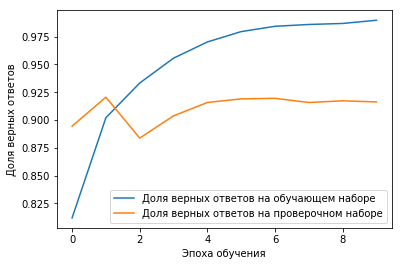

In [0]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
#!cp nlp.hfd5 ./drive/'My Drive'/nlp_bd.hfd5

In [0]:
def create_model3(params):
    input_layer = Input(shape=(maxlen, ), name='input')

    input_dim = embedding_matrix.shape[0]
    output_dim = embedding_matrix.shape[1]
    
    x = Embedding(
        input_dim=input_dim,
        output_dim=output_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    )(input_layer)

    # 2. dropout
    x = SpatialDropout1D(rate=0.2)(x)

    # 3. bidirectional lstm & gru
    x = Bidirectional(
        layer=CuDNNLSTM(128, return_sequences=True),
        name='bidirectional_lstm'
    )(x)
    # (optional), get hidden states
    x = Bidirectional(
        layer=CuDNNGRU(128, return_sequences=True),
        name='bidirectional_gru'
    )(x)
    # 4. concat global_max_pooling1d and attention
    max_pool = GlobalMaxPool1D(name='global_max_pooling1d')(x)
    atten = Attention(step_dim=maxlen, name='attention')(x)
    x = Concatenate(axis=-1)([max_pool, atten])

    # 5. dense
    x = Dense(units=128, activation='relu', name='dense_1')(x)
    x = Dropout(rate=0.15)(x)
    x = Dense(units=16, activation='relu', name='dense_2')(x)
    # 6. output (sigmoid)
    output_layer = Dense(units=1, activation='sigmoid', name='output')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


In [0]:
modfel = create_model3(params)

сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)

history = model.fit(train_X, 
                    train_y, 
                    epochs=10,
                    batch_size=128,
                    callbacks = [сheckpoint],
                    validation_split=0.1,
                    verbose=1)

NameError: ignored